# Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Unpacking

In [2]:
!pip install pyunpack
!pip install patool
!pip install librosa

     |████████████████████████████████| 81kB 5.7MB/s 


# Data Path

In [3]:
TRAIN_AUDIO_PATH = "/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/"

# install library for audio/signal analysis 

In [4]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import os
import shutil
import time

# from waves to spectrograms
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Creating a Data Map

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

labels = os.listdir(TRAIN_AUDIO_PATH)
# creating data map
data_map = {}
for ind, label in enumerate(labels):
    data_path = TRAIN_AUDIO_PATH + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()

dict_keys(['/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/_background_noise_', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/bed', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/bird', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/cat', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/dog', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/down', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/eight', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/five', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/four', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/go', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/happy', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/house', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/left', '/content/drive/MyDrive/IIITD Dataset/Task1/Train/train/audio/marvin', '/content

# Creating Data Frame

In [6]:
data_map = {}
for ind, label in enumerate(labels):
    data_path = TRAIN_AUDIO_PATH + label
    data_map[ind] = label, os.listdir(data_path), ind

    
df = pd.DataFrame(data_map.values(), 
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])

df.reset_index(inplace=True)
rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn]) 
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)

#print(df_new["label_name"].value_counts())

df_new.head()

,label_name,label,path
0,_background_noise_,0,doing_the_dishes.wav
1,_background_noise_,0,README.md
2,_background_noise_,0,dude_miaowing.wav
3,_background_noise_,0,exercise_bike.wav
4,_background_noise_,0,pink_noise.wav


In [7]:
# labels for training - https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data

train_classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

# df with training classes

df1 = df_new.loc[df_new['label_name'].isin(train_classes)].reset_index(drop=True)

# alignment labels for training classes

keys = np.unique(df1['label'])
values = [l for l in range(len(train_classes))]
df1['label'] = df1['label'].replace(keys, values)

classes_for_subbmition = dict(zip(values, train_classes))
classes_for_subbmition[10] = "unknown"

# df as class "unknown" or "silence"

df2 = df_new[~df_new['label_name'].isin(train_classes)].reset_index(drop=True)
df2['label'] = None
df2 = df2.drop(df2[df2['label'].isnull()].sample(38500,random_state=120).index)
df2['label'] = 10

# df for training

train_df = df1.append(df2, ignore_index=True).reset_index(drop=True)
train_df.to_csv(r'speech_commands_dataset_train_labels.csv', index=True)
print(train_df.groupby(["label", "label_name"]).count())
train_df.head()

                          path
label label_name              
0     down                2359
1     go                  2372
2     left                2353
3     no                  2375
4     off                 2357
5     on                  2367
6     right               2367
7     stop                2380
8     up                  2375
9     yes                 2377
10    _background_noise_     1
      bed                   95
      bird                 106
      cat                  113
      dog                  110
      eight                154
      five                 129
      four                 138
      happy                122
      house                106
      marvin               116
      nine                 130
      one                  157
      seven                139
      sheila               111
      six                  154
      three                147
      tree                 101
      two                  128
      wow                  131
      ze

,label_name,label,path
0,down,0,0ff728b5_nohash_0.wav
1,down,0,b12bef84_nohash_0.wav
2,down,0,b3bb4dd6_nohash_1.wav
3,down,0,a8cf01bc_nohash_0.wav
4,down,0,e5dadd24_nohash_0.wav


# Data Generator¶


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms

import cv2

In [9]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, df, data_path, transforms=None):
        self.df = df
        self.data_path = data_path
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        signal_path = self.data_path + self.df.iloc[idx, 0] + "/" + self.df.iloc[idx, 2]
        samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
        freqs, times, spectrogram = log_specgram(samples, sample_rate)
        img = cv2.resize(spectrogram, (256, 256))
        img = np.stack((img,)*3, axis=-1).astype(np.float32())
        label =  self.df.iloc[idx, 1]
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, label

In [10]:
# Split data into training and validation

train_df, val_df = train_test_split(train_df, stratify=train_df.label, test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df.label, test_size=0.1)
print(train_df.shape, val_df.shape, test_df.shape)

# Augmentations for data

aug = transforms.Compose([#transforms.ToPILImage(),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])
# Speech Commands dataset

train_dataset = SpeechCommandsDataset(df=train_df,
                            data_path=TRAIN_AUDIO_PATH,
                            transforms=aug)

val_dataset = SpeechCommandsDataset(df=val_df,
                           data_path=TRAIN_AUDIO_PATH,
                           transforms=aug)

test_dataset = SpeechCommandsDataset(df=test_df,
                           data_path=TRAIN_AUDIO_PATH,
                           transforms=aug)
# Data loader

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)


(21244, 3) (2623, 3) (2361, 3)


# Let's look at the batch of training data.¶


torch.Size([32, 3, 256, 256]) torch.Size([32])


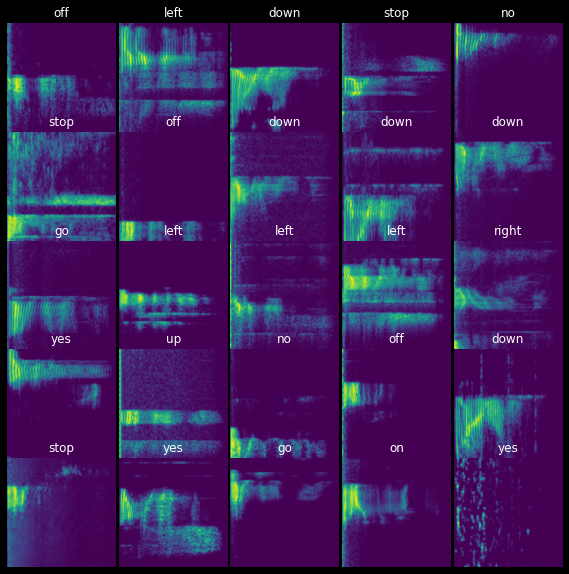

In [11]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

def show_aug(inputs, labels, nrows=5, ncols=5):
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        l_map = train_df.groupby(["label", "label_name"]).count()
        d = {k:list(l_map.loc[k].index) for k in l_map.index.levels[0]}
    
        plt.figure(figsize=(10, 10))
        plt.subplots_adjust(wspace=0., hspace=0.)
        i_ = 0
    
        for idx in range(len(inputs)):

            l = int(labels[idx])
            plt.subplot(nrows, ncols, i_+1).set_title(d[l][0])
            plt.imshow(inputs[idx][0,:]); 
            plt.axis('off')
            i_ += 1

        return plt.show()

    
data, labels = next(iter(train_loader))
print(data.shape, labels.shape)    
    
show_aug(data, labels)

# Training neural net

In [12]:
!pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=3d24b23c206b80a982ba7af009de9ace6cf5458fac2eb5aac766c23e37abb993
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [13]:
import sys
package_path = '../input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.append(package_path)

In [14]:
from efficientnet_pytorch import EfficientNet

# Hyper parameters

num_epochs = 3
num_classes = len(train_df["label"].value_counts())

# Device configuration

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


# Loss and optimizer

In [15]:
optimizer = torch.optim.Adamax(model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [16]:
%%time 

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        print(time.ctime())
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history


def compute_accuracy(model, loader):

    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """

    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            
            indicies = torch.argmax(prediction, 1)
            res = indicies == y_gpu
            correct_samples += torch.sum(res)
            total_samples += y.shape[0]
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, num_epochs)
torch.save(model.state_dict(), 'model.pt')

Sat Apr 10 07:22:46 2021
Average loss: 0.410212, Train accuracy: 0.866268, Val accuracy: 0.929851
Sat Apr 10 10:15:11 2021
Average loss: 0.151536, Train accuracy: 0.950951, Val accuracy: 0.948151
Sat Apr 10 10:19:49 2021
Average loss: 0.107606, Train accuracy: 0.963237, Val accuracy: 0.955013
CPU times: user 9min 7s, sys: 5min 1s, total: 14min 9s
Wall time: 3h 1min 42s


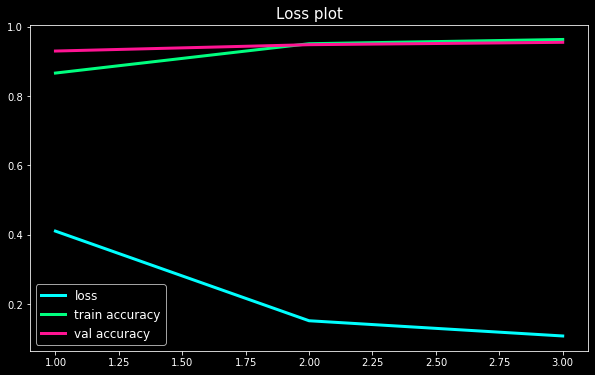

In [17]:
import matplotlib.pyplot as plt

x = np.arange(1, 4)

fig = plt.figure(figsize=(10, 6))
plt.plot(x, loss_history, label='loss',lw=3, c="cyan")
plt.plot(x, train_history, label='train accuracy', lw=3, c="springgreen")
plt.plot(x, val_history, label='val accuracy', lw=3, c="deeppink")

plt.title("Loss plot", fontsize=15)
plt.legend(fontsize=12)

plt.show()

# Test

In [18]:
pred_Y = []
Y = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for p, l in zip(predicted, labels):
            #print(p, l)
            pred_Y.append(p.detach().cpu())
            Y.append(l.detach().cpu())
          
    print('Test Accuracy:  {} %'.format(100 * correct / total))


Test Accuracy:  96.10334603981364 %


# Сonfusion test matrix

In [19]:
y_actual = pd.Series(np.array(Y), name='Actual')
y_pred = pd.Series(np.array(pred_Y), name='Predicted')

y_actual = y_actual.apply(lambda c: classes_for_subbmition[c])
y_pred = y_pred.apply(lambda c: classes_for_subbmition[c])

df_confusion = pd.crosstab(y_actual, y_pred)
df_confusion

Predicted,down,go,left,no,off,on,right,stop,unknown,up,yes
Actual,,,,,,,,,,,
down,208,0,1,0,0,0,2,1,0,2,0
go,1,211,0,1,0,0,0,0,0,1,0
left,0,0,200,3,0,0,1,6,2,0,0
no,12,0,2,195,0,0,0,0,2,2,1
off,0,0,1,0,210,0,0,0,2,0,1
on,0,0,0,0,0,207,3,0,2,1,0
right,0,1,1,1,0,0,206,2,2,0,0
stop,0,1,1,2,0,0,3,207,0,0,0
unknown,2,0,1,1,0,4,4,1,215,1,0


# Plot Confusion Matrix

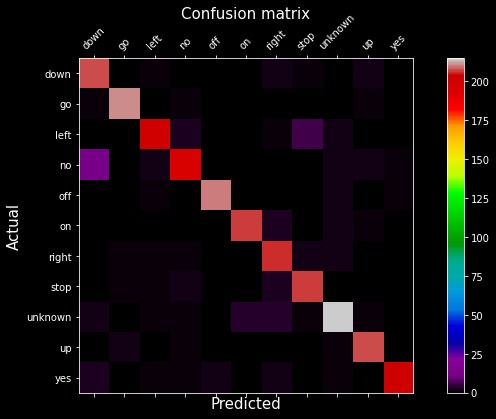

In [21]:
plt.figure(figsize=(12, 6))
plt.matshow(df_confusion, fignum=1, cmap="nipy_spectral") # gist_stern
plt.title("Confusion matrix", fontsize=15, x=0.5, y=1.1)
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel(df_confusion.index.name, fontsize=15)
plt.xlabel(df_confusion.columns.name, fontsize=15)
plt.savefig("confusion_test_matrix.png", bbox_inches='tight', 
            pad_inches=0.2, transparent=False)

# Upload model with pretrained weights




In [22]:
from google.colab import files
files.upload()

Saving model.pt to model (1).pt


In [26]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

from efficientnet_pytorch import EfficientNet
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import cv2

# From waves to spectrograms

In [27]:
# from waves to spectrograms
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Device configuration

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=11)
model = model.to(device)
model.load_state_dict(torch.load('model.pt', map_location='cpu'))
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [23]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
import time

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1, path_to_save= "/content/"):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  fn = str(time.time()) + ".wav"
  audio.export(path_to_save + fn, format="wav")
  return fn, audio

In [29]:
filename, play = record()
print(filename); play

<IPython.core.display.Javascript object>

1618054693.0706072.wav


<IPython.core.display.Javascript object>

AttributeError: ignored

# Prediction

tensor([[-1.9639, -2.5795, -2.1104, -1.7954, -2.1243, -2.1820, -2.7887, -2.5489,
         -3.3066, -3.4750,  1.3146]], device='cuda:0', grad_fn=<AddmmBackward>)
bed


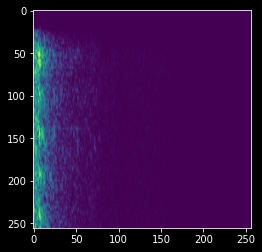

In [ ]:
# Get prediction
labels = ["go", "off", "stop", "up", "no", "right", "down", "left", "on", "yes", "bed"]

path_to_file = "/content/" + filename
samples, sample_rate = librosa.load(path_to_file, mono=True, sr=None)
freqs, times, spectrogram = log_specgram(samples, sample_rate)
img = cv2.resize(spectrogram, (256, 256))
img_rgb = np.stack((img,)*3, axis=-1).astype(np.float32())
plt.imshow(img)

aug = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])

new_tensor = aug(img_rgb)


output = model(new_tensor.unsqueeze(0).to(device))
print(output)
_, prediction = torch.max(output.data, 1)
print(labels[int(prediction)])
play